## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
import ydata_profiling
from sklearn.ensemble import RandomForestRegressor
from ydata_profiling import ProfileReport

import warnings
warnings.filterwarnings(action='ignore')

## Fixed Random-Seed

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

## Load Data

In [3]:
info = pd.read_csv('./building_info.csv')

In [4]:
train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

In [80]:
## Train Data Pre-Processing

In [81]:
help(ydata_profiling)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# 건물번호와 연관된 info정보는 어떤식으로 활용해야할까...?
info

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),PCS용량(kW)
0,1,건물기타,110634.00,39570.00,-,-,-
1,2,건물기타,122233.47,99000.00,-,-,-
2,3,건물기타,171243.00,113950.00,40,-,-
3,4,건물기타,74312.98,34419.62,60,-,-
4,5,건물기타,205884.00,150000.00,-,2557,1000
...,...,...,...,...,...,...,...
95,96,호텔및리조트,93314.00,60500.00,-,-,-
96,97,호텔및리조트,55144.67,25880.00,-,-,-
97,98,호텔및리조트,53578.62,17373.75,-,-,-
98,99,호텔및리조트,53499.00,40636.00,-,-,-


In [18]:
test_df

,num_date_time,건물번호,일시,기온(C),강수량(mm),풍속(m/s),습도(%)
0,1_20220825 00,1,20220825 00,23.5,0.0,2.2,72
1,1_20220825 01,1,20220825 01,23.0,0.0,0.9,72
2,1_20220825 02,1,20220825 02,22.7,0.0,1.5,75
3,1_20220825 03,1,20220825 03,22.1,0.0,1.3,78
4,1_20220825 04,1,20220825 04,21.8,0.0,1.0,77
...,...,...,...,...,...,...,...
16795,100_20220831 19,100,20220831 19,22.5,0.0,0.9,84
16796,100_20220831 20,100,20220831 20,20.7,0.0,0.4,95
16797,100_20220831 21,100,20220831 21,20.2,0.0,0.4,98
16798,100_20220831 22,100,20220831 22,20.1,0.0,1.1,97


100개의 건물 시간단위 데이터

In [6]:
train_profile = ProfileReport(train_df, title = "train")
test_profile= ProfileReport(test_df, title = "test")
# train_profile.to_html()
# test_profile.to_html()

In [84]:
train_profile.to_file("train.html")
test_profile.to_file("test.html")

14151

(train_df.loc[:,"강수량(mm)"]==0).sum()

In [8]:
# 결측값은 0도 아니고 뭘 의미하는걸까?
train_df.loc[:,"강수량(mm)"].isna().sum()

160069

(test_df.loc[:, "강수량(mm)"]==0).sum()

In [10]:
test_df.loc[:,"강수량(mm)"].isna().sum()

0

강수량이 test에서 nan이 없는 관계로 nan을 0으로 치환함
profiling을 봤을때 test의 zeroes 비율이 train의 missing과 zero의 합의 비율과 비슷함

In [11]:
train_df.isna().sum()

num_date_time         0
건물번호                  0
일시                    0
기온(C)                 0
강수량(mm)          160069
풍속(m/s)              19
습도(%)                 9
일조(hr)            75182
일사(MJ/m2)         87913
전력소비량(kWh)            0
dtype: int64

train_df["강수량(mm)"].unique()

In [13]:
train_df["강수량(mm)"][0]

nan

In [ ]:
train_df["강수량(mm)"] = train_df["강수량(mm)"].fillna(0)

In [15]:
train_df["강수량(mm)"].isna().sum()

0

In [16]:
train_df.isna().sum()

num_date_time        0
건물번호                 0
일시                   0
기온(C)                0
강수량(mm)              0
풍속(m/s)             19
습도(%)                9
일조(hr)           75182
일사(MJ/m2)        87913
전력소비량(kWh)           0
dtype: int64

In [13]:
from prophet import Prophet
from prophet.plot import plot
import numpy as np

In [223]:
test_submission= pd.DataFrame(columns=['num_date_time', 'answer'])
for i in range(1,101):

    # print(i)
    # 한건물당 168개씩 예측한다
    sample_train = train_df.loc[train_df["건물번호"]==i]
    sample_train
    target = sample_train["num_date_time"].str.split("_").apply(lambda  x: x[1])
    sample_train["num_date_time"] = pd.to_datetime(target, format = "%Y%m%d %H")
    data = sample_train.rename(columns={'num_date_time': 'ds', "전력소비량(kWh)":'y'})[['ds','y']]

    m= Prophet()
    m.fit(data)
    future = m.make_future_dataframe(periods=168, freq='1H')
    forecast = m.predict(future)

    answer =forecast[-168:].loc[:,['ds','yhat']].rename(columns= {"ds": "num_date_time", "yhat":"answer"}).reset_index(drop=True)

    answer["year"]=answer["num_date_time"].dt.year.astype(str)
    answer["month"]=answer["num_date_time"].dt.month.astype(str).str.zfill(2)
    answer["day"]=answer["num_date_time"].dt.day.astype(str).str.zfill(2)
    answer["hour"]=answer["num_date_time"].dt.hour.astype(str).str.zfill(2)
    answer["num_date_time"] = f"{i}_"+answer["year"] + answer["month"] + answer["day"] +' '+ answer["hour"]
    test_submission = test_submission.append(answer)
test_submission = test_submission[["num_date_time","answer"]]
test_submission.set_index("num_date_time",inplace= True)

16:44:26 - cmdstanpy - INFO - Chain [1] start processing
16:44:26 - cmdstanpy - INFO - Chain [1] done processing
16:44:26 - cmdstanpy - INFO - Chain [1] start processing
16:44:26 - cmdstanpy - INFO - Chain [1] done processing
16:44:27 - cmdstanpy - INFO - Chain [1] start processing
16:44:27 - cmdstanpy - INFO - Chain [1] done processing
16:44:28 - cmdstanpy - INFO - Chain [1] start processing
16:44:28 - cmdstanpy - INFO - Chain [1] done processing
16:44:28 - cmdstanpy - INFO - Chain [1] start processing
16:44:28 - cmdstanpy - INFO - Chain [1] done processing
16:44:29 - cmdstanpy - INFO - Chain [1] start processing
16:44:29 - cmdstanpy - INFO - Chain [1] done processing
16:44:29 - cmdstanpy - INFO - Chain [1] start processing
16:44:29 - cmdstanpy - INFO - Chain [1] done processing
16:44:30 - cmdstanpy - INFO - Chain [1] start processing
16:44:30 - cmdstanpy - INFO - Chain [1] done processing
16:44:31 - cmdstanpy - INFO - Chain [1] start processing
16:44:31 - cmdstanpy - INFO - Chain [1]

In [224]:
test_submission.to_csv("2023-08-05.csv")

### prophet (외생변수/파생변수 X) private smape : 12.7623882251

## 외생변수 삽입

In [72]:
test_submission= pd.DataFrame(columns=['num_date_time', 'answer'])
fillzero_train = train_df.fillna(0)
for i in range(1,101):
    # 한건물당 168개씩 예측한다
    sample_train = fillzero_train.loc[fillzero_train["건물번호"]==i]
    target = sample_train["num_date_time"].str.split("_").apply(lambda  x: x[1])
    sample_train["num_date_time"] = pd.to_datetime(target, format = "%Y%m%d %H")
    data = sample_train.rename(columns={'num_date_time': 'ds', "전력소비량(kWh)":'y'})[['ds','y','기온(C)','강수량(mm)','풍속(m/s)','습도(%)']].reset_index(drop=True)

    m= Prophet()
    m.add_regressor('기온(C)')
    m.add_regressor('강수량(mm)')
    m.add_regressor('풍속(m/s)')
    m.add_regressor('습도(%)')
    m.fit(data)

    future = m.make_future_dataframe(periods=168, freq='1H')
    future['기온(C)'] = data['기온(C)']
    future['강수량(mm)'] = data['강수량(mm)']
    future['풍속(m/s)'] = data['풍속(m/s)']
    future['습도(%)'] = data['습도(%)']

    future.loc[future.shape[0]-168:,'기온(C)'] = test_df.loc[(i-1)*168:i*168-1,'기온(C)'].values
    future.loc[future.shape[0]-168:,'강수량(mm)'] = test_df.loc[(i-1)*168:i*168-1,'강수량(mm)'].values
    future.loc[future.shape[0]-168:,'풍속(m/s)'] = test_df.loc[(i-1)*168:i*168-1,'풍속(m/s)'].values
    future.loc[future.shape[0]-168:,'습도(%)'] = test_df.loc[(i-1)*168:i*168-1,'습도(%)'].values

    forecast = m.predict(future)

    # Rest of the code



    answer =forecast[-168:].loc[:,['ds','yhat']].rename(columns= {"ds": "num_date_time", "yhat":"answer"}).reset_index(drop=True)

    answer["year"]=answer["num_date_time"].dt.year.astype(str)
    answer["month"]=answer["num_date_time"].dt.month.astype(str).str.zfill(2)
    answer["day"]=answer["num_date_time"].dt.day.astype(str).str.zfill(2)
    answer["hour"]=answer["num_date_time"].dt.hour.astype(str).str.zfill(2)
    answer["num_date_time"] = f"{i}_"+answer["year"] + answer["month"] + answer["day"] +' '+ answer["hour"]
    test_submission = test_submission.append(answer)
test_submission = test_submission[["num_date_time","answer"]]
test_submission.set_index("num_date_time",inplace= True)

12:49:26 - cmdstanpy - INFO - Chain [1] start processing
12:49:26 - cmdstanpy - INFO - Chain [1] done processing
12:49:26 - cmdstanpy - INFO - Chain [1] start processing
12:49:27 - cmdstanpy - INFO - Chain [1] done processing
12:49:27 - cmdstanpy - INFO - Chain [1] start processing
12:49:27 - cmdstanpy - INFO - Chain [1] done processing
12:49:27 - cmdstanpy - INFO - Chain [1] start processing
12:49:28 - cmdstanpy - INFO - Chain [1] done processing
12:49:28 - cmdstanpy - INFO - Chain [1] start processing
12:49:28 - cmdstanpy - INFO - Chain [1] done processing
12:49:28 - cmdstanpy - INFO - Chain [1] start processing
12:49:29 - cmdstanpy - INFO - Chain [1] done processing
12:49:29 - cmdstanpy - INFO - Chain [1] start processing
12:49:29 - cmdstanpy - INFO - Chain [1] done processing
12:49:29 - cmdstanpy - INFO - Chain [1] start processing
12:49:30 - cmdstanpy - INFO - Chain [1] done processing
12:49:30 - cmdstanpy - INFO - Chain [1] start processing
12:49:30 - cmdstanpy - INFO - Chain [1]

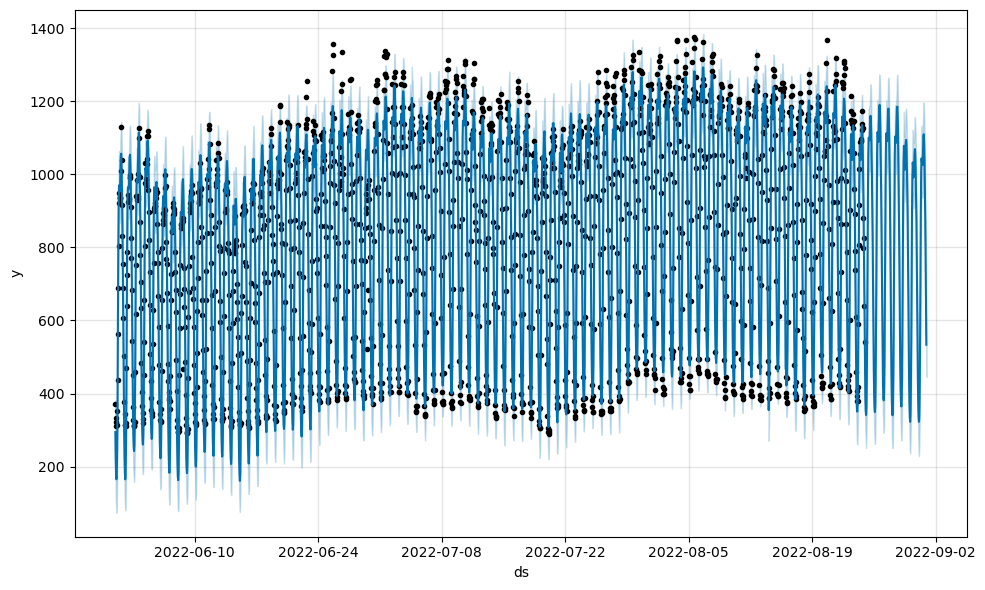

In [74]:
fig = m.plot(forecast)

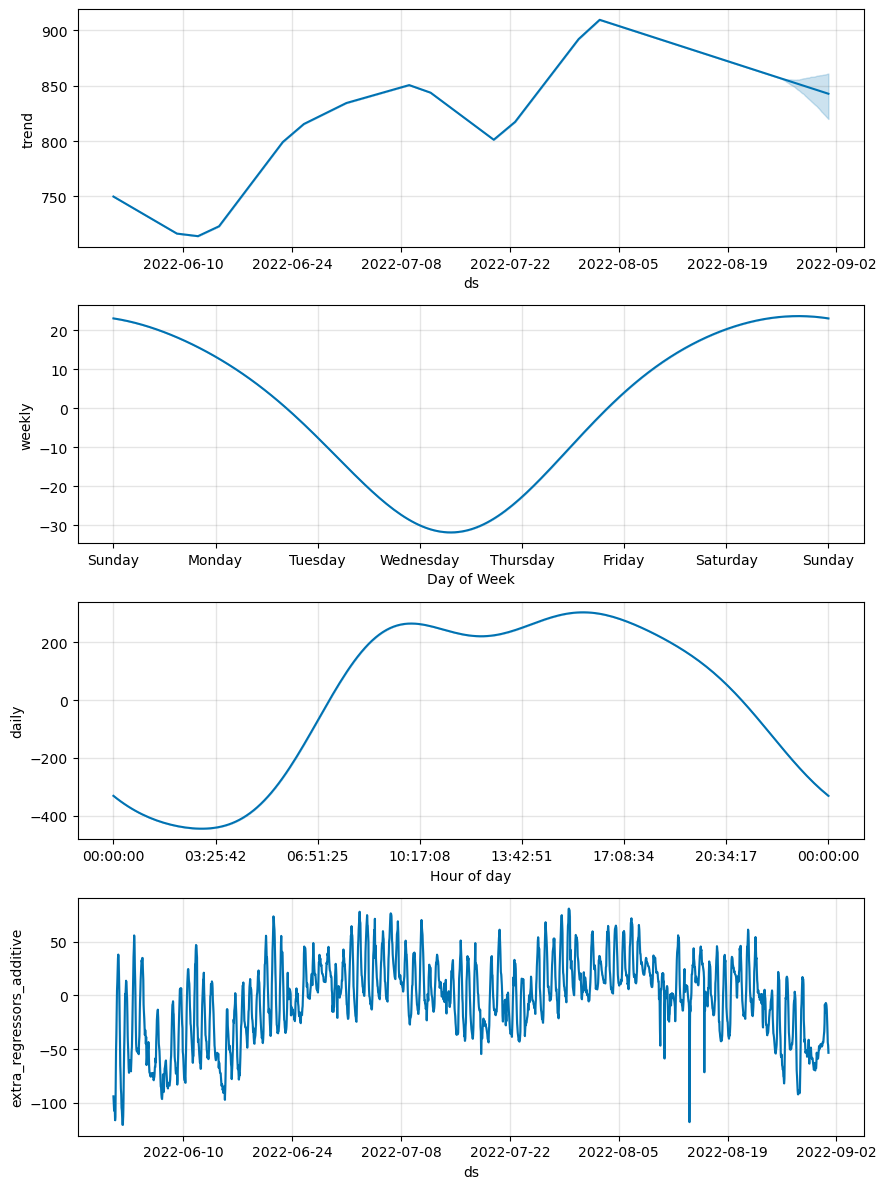

In [75]:
fig = m.plot_components(forecast)

In [76]:
test_submission.to_csv("2023-08-06.csv")

## smape : 11.4580198854

## 일조량, 일사량 선형 보간법 및 test셋용 파생변수 만들기

In [79]:
train_df["강수량(mm)"] = train_df["강수량(mm)"].fillna(0)

In [80]:
train_df.isna().sum()

num_date_time        0
건물번호                 0
일시                   0
기온(C)                0
강수량(mm)              0
풍속(m/s)             19
습도(%)                9
일조(hr)           75182
일사(MJ/m2)        87913
전력소비량(kWh)           0
dtype: int64

In [98]:
# 선형 linear interpolate는 일조량 일사량에서 각 6개의 결측값을 가지고 이것을 0으로 바꿈
linear_train_df = train_df.interpolate().fillna(0)


In [151]:
test_submission= pd.DataFrame(columns=['num_date_time', 'answer'])

for i in range(1,101):
# 한건물당 168개씩 예측한다
    linear_train_df = train_df.interpolate().fillna(0)
    sample_train = fillzero_train.loc[fillzero_train["건물번호"]==i]
    target = sample_train["num_date_time"].str.split("_").apply(lambda  x: x[1])
    sample_train["num_date_time"] = pd.to_datetime(target, format = "%Y%m%d %H")
    data = sample_train.rename(columns={'num_date_time': 'ds', "전력소비량(kWh)":'y'})[['ds','y','기온(C)','강수량(mm)','풍속(m/s)','습도(%)','일조(hr)','일사(MJ/m2)']].reset_index(drop=True)

    m= Prophet()
    m.add_regressor('기온(C)')
    m.add_regressor('강수량(mm)')
    m.add_regressor('풍속(m/s)')
    m.add_regressor('습도(%)')
    m.add_regressor('일조(hr)')
    m.add_regressor('일사(MJ/m2)')
    m.fit(data)

    future = m.make_future_dataframe(periods=168, freq='1H')
    future['기온(C)'] = data['기온(C)']
    future['강수량(mm)'] = data['강수량(mm)']
    future['풍속(m/s)'] = data['풍속(m/s)']
    future['습도(%)'] = data['습도(%)']
    future['일조(hr)'] = data['일조(hr)']
    future['일사(MJ/m2)'] = data['일사(MJ/m2)']
    sample_train_l = linear_train_df.loc[linear_train_df["건물번호"]==i]
    target = sample_train_l["num_date_time"].str.split("_").apply(lambda  x: x[1])
    sample_train_l["num_date_time"] = pd.to_datetime(target, format = "%Y%m%d %H")

    data_l = sample_train_l.rename(columns={'num_date_time': 'ds', "일조(hr)":'y'})
    lm = Prophet()
    lm.fit(data_l)
    future_l = lm.make_future_dataframe(periods=168, freq='1H')
    forecast_l = lm.predict(future_l)
    # forecast_l
    answer_l =forecast_l[-168:].loc[:,['ds','yhat']].rename(columns= {"ds": "num_date_time", "yhat":"answer"}).reset_index(drop=True)
    answer_l.loc[answer_l['answer']<0,'answer'] = 0

    sample_train_lj = linear_train_df.loc[linear_train_df["건물번호"]==i]
    target_lj = sample_train_lj["num_date_time"].str.split("_").apply(lambda  x: x[1])
    sample_train_lj["num_date_time"] = pd.to_datetime(target_lj, format = "%Y%m%d %H")

    data_lj = sample_train_lj.rename(columns={'num_date_time': 'ds', "일사(MJ/m2)":'y'})
    ljm = Prophet()
    ljm.fit(data_lj)
    future_lj = ljm.make_future_dataframe(periods=168, freq='1H')
    forecast_lj = ljm.predict(future_lj)
    # forecast_lj
    answer_lj =forecast_lj[-168:].loc[:,['ds','yhat']].rename(columns= {"ds": "num_date_time", "yhat":"answer"}).reset_index(drop=True)
    answer_lj.loc[answer_lj['answer']<0,'answer'] = 0

    future.loc[future.shape[0]-168:,'기온(C)'] = test_df.loc[(i-1)*168:i*168-1,'기온(C)'].values
    future.loc[future.shape[0]-168:,'강수량(mm)'] = test_df.loc[(i-1)*168:i*168-1,'강수량(mm)'].values
    future.loc[future.shape[0]-168:,'풍속(m/s)'] = test_df.loc[(i-1)*168:i*168-1,'풍속(m/s)'].values
    future.loc[future.shape[0]-168:,'습도(%)'] = test_df.loc[(i-1)*168:i*168-1,'습도(%)'].values
    future.loc[future.shape[0]-168:,'일조(hr)'] = answer_l.iloc[:,1].values
    future.loc[future.shape[0]-168:,'일사(MJ/m2)'] = answer_lj.iloc[:,1].values

    forecast = m.predict(future)

    # Rest of the code



    answer =forecast[-168:].loc[:,['ds','yhat']].rename(columns= {"ds": "num_date_time", "yhat":"answer"}).reset_index(drop=True)

    answer["year"]=answer["num_date_time"].dt.year.astype(str)
    answer["month"]=answer["num_date_time"].dt.month.astype(str).str.zfill(2)
    answer["day"]=answer["num_date_time"].dt.day.astype(str).str.zfill(2)
    answer["hour"]=answer["num_date_time"].dt.hour.astype(str).str.zfill(2)
    answer["num_date_time"] = f"{i}_"+answer["year"] + answer["month"] + answer["day"] +' '+ answer["hour"]
    test_submission = test_submission.append(answer)
test_submission = test_submission[["num_date_time","answer"]]
test_submission.set_index("num_date_time",inplace= True)

13:40:23 - cmdstanpy - INFO - Chain [1] start processing
13:40:23 - cmdstanpy - INFO - Chain [1] done processing
13:40:24 - cmdstanpy - INFO - Chain [1] start processing
13:40:24 - cmdstanpy - INFO - Chain [1] done processing
13:40:24 - cmdstanpy - INFO - Chain [1] start processing
13:40:24 - cmdstanpy - INFO - Chain [1] done processing
13:40:25 - cmdstanpy - INFO - Chain [1] start processing
13:40:25 - cmdstanpy - INFO - Chain [1] done processing
13:40:25 - cmdstanpy - INFO - Chain [1] start processing
13:40:25 - cmdstanpy - INFO - Chain [1] done processing
13:40:26 - cmdstanpy - INFO - Chain [1] start processing
13:40:26 - cmdstanpy - INFO - Chain [1] done processing
13:40:26 - cmdstanpy - INFO - Chain [1] start processing
13:40:26 - cmdstanpy - INFO - Chain [1] done processing
13:40:27 - cmdstanpy - INFO - Chain [1] start processing
13:40:27 - cmdstanpy - INFO - Chain [1] done processing
13:40:27 - cmdstanpy - INFO - Chain [1] start processing
13:40:27 - cmdstanpy - INFO - Chain [1]

In [88]:
help(train_df.interpolate)

Help on method interpolate in module pandas.core.frame:

interpolate(method: 'str' = 'linear', *, axis: 'Axis' = 0, limit: 'int | None' = None, inplace: 'bool' = False, limit_direction: 'str | None' = None, limit_area: 'str | None' = None, downcast: 'str | None' = None, **kwargs) -> 'DataFrame | None' method of pandas.core.frame.DataFrame instance
    Fill NaN values using an interpolation method.
    
    Please note that only ``method='linear'`` is supported for
    DataFrame/Series with a MultiIndex.
    
    Parameters
    ----------
    method : str, default 'linear'
        Interpolation technique to use. One of:
    
        * 'linear': Ignore the index and treat the values as equally
          spaced. This is the only method supported on MultiIndexes.
        * 'time': Works on daily and higher resolution data to interpolate
          given length of interval.
        * 'index', 'values': use the actual numerical values of the index.
        * 'pad': Fill in NaNs using existing

In [152]:
test_submission.to_csv("2023-08-06_d.csv")